## 4.2最新版训练Unet全流程
    包含 random随机种子存储，大图预处理(包含旋转，缩放，色彩对比度范围随机变化，图像填充裁切)，patch分割，训练，存储model，测试model。

### 加载基本库

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import gc

# 封装的函数模块，model部分全部引用
from functions.data import prepare_dataset,get_optimized_loaders
from functions.model import *
from functions.data import SegmentationDataset
from functions.imagePreprocessing import ImagePreprocessor


### 数据集准备

In [2]:
train_data, test_data = prepare_dataset("Kasthuri++")
# train_data, test_data = prepare_dataset("Lucchi++")

# 第一次运行时：预处理并保存
train_dataset = SegmentationDataset(
    data_list=train_data,
    patch_size=256,
    stride=128,
    preProcess=True,  # 启用预处理

)

test_dataset = SegmentationDataset(
    data_list=test_data,
    patch_size=256,
    stride=128,
    preProcess=True,  # 启用预处理

)

train_loader, test_loader = get_optimized_loaders(
    train_dataset, 
    test_dataset, 
    batch_size=32,  # 增加批大小
    num_workers=4
)



Train Data (Kasthuri++): [{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png', 'index': 0}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png', 'index': 1}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png', 'index': 2}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png', 'index': 3}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png', 'index': 4}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png', 'index': 5}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png', 'index': 6}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038

处理图像: 100%|██████████| 85/85 [00:30<00:00,  2.75it/s]


数据集预处理完成，共生成 12595 个patch
开始数据集预处理...


处理图像: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]

数据集预处理完成，共生成 9289 个patch


### 训练Unet模型阶段

In [3]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(num_classes=1).to(device)

cuda


#### 开始训练

In [4]:
optimized_train_model(model, train_loader, test_loader, num_epochs=50, device=device)


Epoch 1/50:
Training - Loss: 0.2372, IoU: 0.4543, Dice: 0.6032
Validation - Loss: 0.0861, IoU: 0.5724, Dice: 0.7003
------------------------------------------------------------
Epoch 2/50:
Training - Loss: 0.0638, IoU: 0.6778, Dice: 0.8062
Validation - Loss: 0.0565, IoU: 0.6203, Dice: 0.7403
------------------------------------------------------------
Epoch 3/50:
Training - Loss: 0.0448, IoU: 0.7323, Dice: 0.8439
Validation - Loss: 0.0501, IoU: 0.6416, Dice: 0.7583
------------------------------------------------------------
Epoch 4/50:
Training - Loss: 0.0363, IoU: 0.7758, Dice: 0.8728
Validation - Loss: 0.0490, IoU: 0.6366, Dice: 0.7530
------------------------------------------------------------
Epoch 5/50:
Training - Loss: 0.0313, IoU: 0.8068, Dice: 0.8925
Validation - Loss: 0.0479, IoU: 0.6539, Dice: 0.7672
------------------------------------------------------------
Epoch 6/50:
Training - Loss: 0.0279, IoU: 0.8297, Dice: 0.9064
Validation - Loss: 0.0483, IoU: 0.6653, Dice: 0.7762

KeyboardInterrupt: 

#### 可选保存模型

In [ ]:
# Save model
torch.save(model.state_dict(), "models/UnetTrain/overlaping_unet_segmentation_try4.2V0A1K.pth")

### 测试model性能


=== 处理图像: mask0022 ===
设备: cuda, 模型: overlaping_unet_segmentation_try4.13k_random2_iou.pth
Patch尺寸: 256, 步长: 128
模型已从 models/UnetTrain/overlaping_unet_segmentation_try4.13k_random2_iou.pth 加载
掩码检测: 前景值=255, 形状=(768, 1024)
评估指标: IoU=0.7322, Dice=0.8454
评估结果: IoU=0.7265, Dice=0.8416
最终评估指标: IoU=0.7265, Dice=0.8416


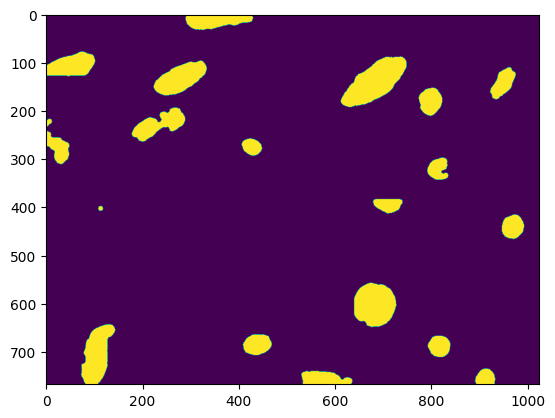

In [3]:
## 4.2最新的predict全流程设置
# 设置参数
model_path = "models/UnetTrain/overlaping_unet_segmentation_try4.13k_random2_iou.pth"  # 模型路径

image_path = "dataset/Lucchi++/Test_In/mask0022.png"  # 测试图片路径
mask_path = "dataset/Lucchi++/Test_Out/22.png"  # 真实掩码路径（如果有）

# image_path = "dataset/Kasthuri++/Test_In/mask1049.png"  
# mask_path = "dataset/Kasthuri++/Test_Out/mask1049.png"  


# image_path = "dataset/VNC/Test_In/16.tif"  
# mask_path = "dataset/VNC/Test_Out/16.png"  

save_dir = "test/predictData"  # 结果保存目录
patch_size = 256  # patch大小
stride = 128  # 步长

# 执行分割流程
pred_mask, metrics = segmentation_pipeline(
    model_path=model_path,
    image_path=image_path,
    mask_path=mask_path,
    save_dir=save_dir,
    patch_size=patch_size,
    stride=stride,
    value=-30,
    alpha=1.0
)

if metrics:
    print(f"最终评估指标: IoU={metrics['IoU']:.4f}, Dice={metrics['Dice']:.4f}")
    
plt.imshow(pred_mask)
plt.show()

In [ ]:
# 处理特定图像列表
image_list = ["img1.png", "img2.png", "img3.png"]
mask_list = ["mask1.png", "mask2.png", "mask3.png"]

results = batch_segmentation_pipeline(
    model_path="models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth",
    image_paths=image_list,
    mask_paths=mask_list,
    save_dir="test/batch_predictData",
    patch_size=256,
    stride=128,
    value=-30,
    alpha=1.0
)


开始批量处理 3 张图像...

处理图像 1/3: img1
处理图像: img1
使用设备: cuda
模型路径: models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth


FileNotFoundError: [Errno 2] No such file or directory: 'models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth'

### 批处理测试model效果，并保存结果同时生成对应的文件(可用，速度一般,1张图大概6s左右)

In [2]:
# 处理整个目录
results = batch_segmentation_pipeline(
    model_path="models/UnetTrain/overlaping_unet_segmentation_try4.13k_random2_iou.pth",
    image_paths="dataset/Lucchi++/Test_In",  # 图像目录
    mask_paths="dataset/Lucchi++/Test_Out",  # 掩码目录
    save_dir="test/batch_predictData",
    patch_size=256,
    stride=128,
    value=-30,
    alpha=1.0
)


开始处理 165 个样本...


 处理进度 1/165: mask0000

=== 处理图像: mask0000 ===
设备: cuda, 模型: overlaping_unet_segmentation_try4.13k_random2_iou.pth
Patch尺寸: 256, 步长: 128
评估指标: IoU=0.8138, Dice=0.8974
二值化前的图像范围: 0-255
二值化阈值: 127
二值化后白色像素数: 67913
denoise评估结果: IoU=0.8108, Dice=0.8955


 处理进度 2/165: mask0001

=== 处理图像: mask0001 ===
设备: cuda, 模型: overlaping_unet_segmentation_try4.13k_random2_iou.pth
Patch尺寸: 256, 步长: 128
评估指标: IoU=0.8213, Dice=0.9019
二值化前的图像范围: 0-255
二值化阈值: 127
二值化后白色像素数: 69780
denoise评估结果: IoU=0.8211, Dice=0.9018


 处理进度 3/165: mask0002

=== 处理图像: mask0002 ===
设备: cuda, 模型: overlaping_unet_segmentation_try4.13k_random2_iou.pth
Patch尺寸: 256, 步长: 128
评估指标: IoU=0.8003, Dice=0.8891
二值化前的图像范围: 0-255
二值化阈值: 127
二值化后白色像素数: 66826
denoise评估结果: IoU=0.7918, Dice=0.8838


 处理进度 4/165: mask0003

=== 处理图像: mask0003 ===
设备: cuda, 模型: overlaping_unet_segmentation_try4.13k_random2_iou.pth
Patch尺寸: 256, 步长: 128
评估指标: IoU=0.7660, Dice=0.8675
二值化前的图像范围: 0-255
二值化阈值: 127
二值化后白色像素数: 65419
denoise评估结果: IoU=0.7

: 

4.13遇到的问题：
 首先是K测L的泛化很低，因为之前只是针对单张图片导致我错判以为IoU很高，实际上只有0.08
 太低了，然后我尝试在分析情况发现一个问题，就是equalization带来的影响很大，甚至可以说直方图的均值后的分布直接决定了Iou，也就是说我equalization大概率写的不好，导致它均值的时候对不同图片效果不同，简单来说那几张很特殊IOU很高的图，它们的均值图都是很平均的一条线，而其它的图军之后基本跟原本的直方图分布差不多。。

批量重命名文件

In [2]:
import os
import re

def rename_files_with_padded_numbers(folder_path, prefix="mask"):
    """
    将文件夹内的数字文件名重命名为带前缀和补零格式
    
    参数:
        folder_path (str): 目标文件夹路径
        prefix (str): 要添加的前缀（默认为"mask"）
    """
    for filename in os.listdir(folder_path):
        old_path = os.path.join(folder_path, filename)
        
        if os.path.isfile(old_path):
            # 使用正则表达式提取数字部分
            match = re.match(r'^(\d+)\.(.*?)$', filename)
            if match:
                number = match.group(1)
                ext = match.group(2)
                
                # 将数字转为4位数（前面补零）
                padded_number = f"{int(number):04d}"
                
                # 新文件名
                new_filename = f"{prefix}{padded_number}.{ext}"
                new_path = os.path.join(folder_path, new_filename)
                
                # 重命名文件
                os.rename(old_path, new_path)
                print(f"已重命名: {filename} -> {new_filename}")

if __name__ == "__main__":
    folder = "dataset/Lucchi++/Test_Out"
    prefix = input("请输入要添加的前缀(默认为'mask'，直接回车使用默认值): ") or "mask"
    
    rename_files_with_padded_numbers(folder, prefix)
    print("所有文件重命名完成！")

已重命名: 10.png -> mask0010.png
已重命名: 100.png -> mask0100.png
已重命名: 101.png -> mask0101.png
已重命名: 102.png -> mask0102.png
已重命名: 103.png -> mask0103.png
已重命名: 104.png -> mask0104.png
已重命名: 105.png -> mask0105.png
已重命名: 106.png -> mask0106.png
已重命名: 107.png -> mask0107.png
已重命名: 108.png -> mask0108.png
已重命名: 109.png -> mask0109.png
已重命名: 11.png -> mask0011.png
已重命名: 110.png -> mask0110.png
已重命名: 111.png -> mask0111.png
已重命名: 112.png -> mask0112.png
已重命名: 113.png -> mask0113.png
已重命名: 114.png -> mask0114.png
已重命名: 115.png -> mask0115.png
已重命名: 116.png -> mask0116.png
已重命名: 117.png -> mask0117.png
已重命名: 118.png -> mask0118.png
已重命名: 119.png -> mask0119.png
已重命名: 12.png -> mask0012.png
已重命名: 120.png -> mask0120.png
已重命名: 121.png -> mask0121.png
已重命名: 122.png -> mask0122.png
已重命名: 123.png -> mask0123.png
已重命名: 124.png -> mask0124.png
已重命名: 125.png -> mask0125.png
已重命名: 126.png -> mask0126.png
已重命名: 127.png -> mask0127.png
已重命名: 128.png -> mask0128.png
已重命名: 129.png -> mask0129.png
已重命名: 13.png 